## This notebook will be used to analyze the results of the baseline classifiers and generate graphics for the report/presentation.

In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re

# Define a function to extract metrics from the text
def extract_metrics(text):
    metrics = {}

    # More flexible regex patterns to account for variations
    accuracy_pattern = r"Accuracy\s*:\s*([\d.]+)"
    precision_pattern = r"Precision\s*:\s*([\d.]+)"
    recall_pattern = r"Recall\s*:\s*([\d.]+)"
    f1_pattern = r"F1\s*:\s*([\d.]+)"
    roc_auc_pattern = r"ROC\s*AUC\s*:\s*([\d.]+)"
    pr_auc_pattern = r"PR\s*AUC\s*:\s*([\d.]+)"
    confusion_matrix_pattern = r"Confusion\s*Matrix\s*:\s*TP:\s*(\d+),\s*FP:\s*(\d+),\s*TN:\s*(\d+),\s*FN:\s*(\d+)"

    # Combine multiple lines by removing newlines before applying regex
    text = re.sub(r'\n', ' ', text)

    # Extract metrics with flexible space handling
    metrics['Accuracy'] = re.search(accuracy_pattern, text).group(1) if re.search(accuracy_pattern, text) else None
    metrics['Precision'] = re.search(precision_pattern, text).group(1) if re.search(precision_pattern, text) else None
    metrics['Recall'] = re.search(recall_pattern, text).group(1) if re.search(recall_pattern, text) else None
    metrics['F1'] = re.search(f1_pattern, text).group(1) if re.search(f1_pattern, text) else None
    metrics['ROC AUC'] = re.search(roc_auc_pattern, text).group(1) if re.search(roc_auc_pattern, text) else None
    metrics['PR AUC'] = re.search(pr_auc_pattern, text).group(1) if re.search(pr_auc_pattern, text) else None

    confusion_matrix_match = re.search(confusion_matrix_pattern, text)
    if confusion_matrix_match:
        metrics['TP'] = confusion_matrix_match.group(1)
        metrics['FP'] = confusion_matrix_match.group(2)
        metrics['TN'] = confusion_matrix_match.group(3)
        metrics['FN'] = confusion_matrix_match.group(4)

    return metrics

# Define a function to parse the metrics from the content directly
def parse_metrics_content(content):
    # Initialize a dictionary to store metrics for each section
    all_metrics = {}

    # Split the content manually by sections
    sections = ['Train', 'Validation', 'Test']
    section_splits = {}

    # Find where each section starts
    for section in sections:
        pattern = re.compile(f"{section}", re.DOTALL)
        match = pattern.search(content)
        if match:
            start = match.start()
            section_splits[section] = start

    # Sort sections by their position in the text
    sorted_sections = sorted(section_splits.items(), key=lambda x: x[1])

    # Loop through sorted sections and extract text for each section
    for i, (section, start_pos) in enumerate(sorted_sections):
        # Determine the end position of the section
        end_pos = sorted_sections[i + 1][1] if i + 1 < len(sorted_sections) else len(content)

        # Extract section text
        section_text = content[start_pos:end_pos]

        # Extract metrics for this section
        metrics = extract_metrics(section_text)
        all_metrics[section] = metrics

    # Convert metrics to a pandas DataFrame for better visualization
    return pd.DataFrame(all_metrics)

logreg_dict = {}
rf_dict = {}
root_dir = "/Users/agreic/Desktop/testing_dir/fit_output/"
# Inside the root_dir, we have directories with the names of the different markers:
for marker in os.listdir(root_dir):
    # IGNORE HIDDEN FILES
    if marker[0] == ".":
        continue
    # Inside each marker directory, we have two subdirectories: "logreg" and "rf".
    for model in os.listdir(root_dir + marker):
        # IGNORE HIDDEN FILES
        if model[0] == ".":
            continue
        # Inside the logreg dir, we have subdirectories named "2d" and "3d".
        # inside of those, there are "metrics" files.
        if model == "logreg":
            for dim in os.listdir(root_dir + marker + "/logreg"):
                if dim[0] == ".":
                    continue
                for file in os.listdir(root_dir + marker + "/logreg/" + dim):
                    if "metrics" in file:
                        # Read the text file.
                        data = (root_dir + marker + "/logreg/" + dim + "/" + file)
                        # Read the whole text file into a variable text:
                        with open(data, "r") as f:
                            text = f.read()    
                        data_frame = parse_metrics_content(text)
                        # Add to a dictionary with the key created as a combination of marker and file name.
                        logreg_dict[marker + "_" + file] = data_frame
        # Inside the rf dir, we have csv files with the metrics for 2d, 3d and val and test data.
        if model == "rf":
            for file in os.listdir(root_dir + marker + "/rf"):
                if "results" in file:
                    # Read the csv file.
                    data = (root_dir + marker + "/rf/" + file)
                    data_frame = pd.read_csv(data)
                    # Add to a dictionary with the key created as a combination of marker and file name.
                    rf_dict[marker + "_" + file] = data_frame

In [168]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_logreg_plot_df(logreg_dict):
    markers = []
    for key in logreg_dict.keys():
        markers.append(key.split("_")[0])
    markers = list(set(markers))

    # Initialize an empty list to hold data for plotting
    plot_data = []

    # We will only use the Test data.
    for filename, data in logreg_dict.items():
        marker = filename.split("_")[0]
        dim = filename.split("_")[2].replace(".txt", "")

        # Extract the Test data
        test_data = data["Test"]

        # Append each metric to the plot_data list as a dictionary
        for metric in ['Accuracy', 'Precision', 'Recall', 'F1']:
            if metric in test_data:
                plot_data.append({
                    'Marker': marker,
                    'Dimension': dim,
                    'Metric': metric,
                    'Value': float(test_data[metric]) if test_data[metric] is not None else None
                })

    # Convert list of dictionaries to a DataFrame for Seaborn
    plot_df = pd.DataFrame(plot_data)
    return plot_df

# Example call with logreg_dict data (assuming logreg_dict is structured correctly)
df = get_logreg_plot_df(logreg_dict)
# print(df)
metric_value = {'Accuracy': 1, 'Precision': 5.0, 'Recall': 7.0, 'F1': 3.0}
dim_value = {'2d' : 0, '3d' : 1}
df['x_positional_encoding'] = df['Dimension'].map(dim_value) + df['Metric'].map(metric_value)
# df['y_connecting_encoding'] = (df['Marker'] +  str(df['Metric'].map(metric_value))).replace('\n', '', regex=True)


In [169]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Set the style for the plots
# sns.set(style="ticks")  # Change to "ticks" for cleaner edges

# # Create the bar plot
# plt.figure(figsize=(12, 6))
# palette = sns.color_palette("Set2", n_colors=len(df['Marker'].unique()))

# # Use `hue` for differentiation and `dodge` to separate bars
# sns.barplot(
#     data=df,
#     x='Metric',
#     y='Value',
#     hue='Marker',
#     palette=palette,
#     dodge=True,
#     alpha=.5,  # Set a general alpha
# )

# # Add a second layer for 3D metrics with less transparency
# sns.barplot(
#     data=df[df['Dimension'] == '3d'],
#     x='Metric',
#     y='Value',
#     hue='Marker',
#     palette=palette,
#     dodge=True,
#     alpha=.50,  # Full opacity for 3D bars
# )

# # Customizing the axes
# plt.title("Comparison of 2D vs 3D Metrics for Each Marker", fontsize=16)
# plt.xlabel("")
# plt.ylabel("")

# # Customize ticks: only keep 0 and 1
# plt.xticks(rotation=45)
# plt.yticks([0, 1])  # Set y-ticks to only 0 and 1

# # Remove unnecessary gridlines and top/right spines
# sns.despine()

# # Show the plot
# plt.legend(title="Marker", loc='upper right')
# plt.show()


In [170]:
# # Set up one big plot
# fig, ax = plt.subplots(figsize=(10, 6))

# # Define a color palette for markers
# palette = {
#     'PU1': 'blue',
#     'SCA1': 'orange',
#     'GATA1': 'green',
#     'CD41': 'red'
# }

# for marker in df['Marker'].unique():
#     # if marker != 'CD41':
#     #     continue
#     # Filter the data for the current marker
#     marker_data = df[df['Marker'] == marker]

#     # Set the x and y positions for the points
#     x_pos = marker_data['x_positional_encoding']
#     y_pos = marker_data['Value']

#     # Set the bar color
#     color = palette[marker]

#     # Plot lines. Pos encoding 1 and 2, then 3 and 4, then 5 and 6, etc.
#     sub1 = marker_data[(marker_data['x_positional_encoding'] == 1) | (marker_data['x_positional_encoding'] == 2)]
#     ax.plot(sub1['x_positional_encoding'], sub1['Value'], label=marker, color=color, marker='o', linestyle='-', linewidth=1)

#     sub2 = marker_data[(marker_data['x_positional_encoding'] == 3) | (marker_data['x_positional_encoding'] == 4)]
#     ax.plot(sub2['x_positional_encoding'], sub2['Value'], label=marker, color=color, marker='o', linestyle='-', linewidth=1)

#     sub3 = marker_data[(marker_data['x_positional_encoding'] == 5) | (marker_data['x_positional_encoding'] == 6)]
#     ax.plot(sub3['x_positional_encoding'], sub3['Value'], label=marker, color=color, marker='o', linestyle='-', linewidth=1)

#     sub4 = marker_data[(marker_data['x_positional_encoding'] == 7) | (marker_data['x_positional_encoding'] == 8)]
#     ax.plot(sub4['x_positional_encoding'], sub4['Value'], label=marker, color=color, marker='o', linestyle='-', linewidth=1)


# # Set labels and title
# ax.set_xlabel('Metrics (Positional Encoding)')
# ax.set_ylabel('Value')
# ax.set_title('Metric Comparison between 2D and 3D by Marker')
# ax.legend()
# ax.grid()
# # ax.log_scale = True
# plt.tight_layout()
# plt.show()

# print(df[df['Marker'] == 'CD41'])

## LOGREG PLOT

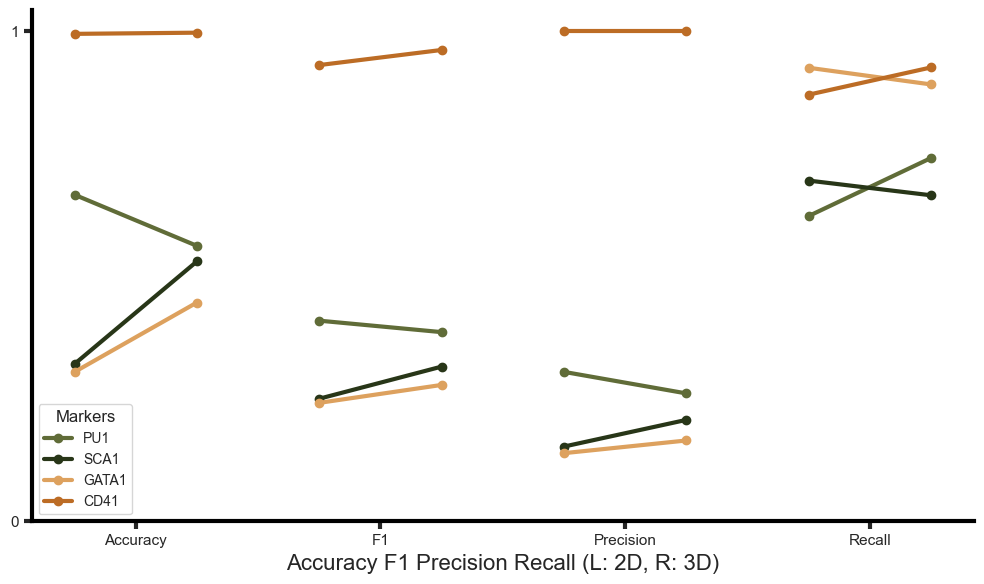

In [171]:
# Set up one big plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define a new color palette for markers (more harmonious colors)
palette = {
    'PU1': '#1f77b4',   # muted blue
    'SCA1': '#ff7f0e',  # muted orange
    'GATA1': '#2ca02c', # muted green
    'CD41': '#d62728'   # muted red
}

palette = {
    'PU1': '#3CB371',   # Medium Sea Green
    'SCA1': '#4682B4',  # Steel Blue
    'GATA1': '#5F9EA0', # Cadet Blue
    'CD41': '#7B68EE'   # Medium Slate Blue
}

palette = {
    'PU1': '#606c38',
    'SCA1': '#283618',
    #fefae0
    'GATA1': '#dda15e',
    'CD41': '#bc6c25'
}

for marker in df['Marker'].unique():
    # Filter the data for the current marker
    marker_data = df[df['Marker'] == marker]

    # Set the bar color
    color = palette[marker]

    # Plot lines. Pos encoding 1 and 2, then 3 and 4, then 5 and 6, etc.
    for i in range(1, 9, 2):
        sub = marker_data[(marker_data['x_positional_encoding'] == i) | (marker_data['x_positional_encoding'] == i + 1)]
        ax.plot(sub['x_positional_encoding'], sub['Value'], label=marker if i == 1 else "", color=color, marker='o', linestyle='-', linewidth=3)

# Customize axes
ax.set_xticks([1.5, 3.5, 5.5, 7.5], labels=['Accuracy', 'F1', 'Precision', 'Recall'])
ax.set_yticks([0, 1])  # Set y-ticks to only show 0 and 1
# Change spine colors
for spine in ax.spines.values():
    spine.set_color('black')
ax.spines['top'].set_visible(False)  # Remove top spine
ax.spines['right'].set_visible(False)  # Remove right spine
ax.spines['left'].set_linewidth(3)  # Increase left spine thickness
ax.spines['bottom'].set_linewidth(3)  # Increase bottom spine thickness
ax.tick_params(axis='both', which='both', width=3)  # Increase tick width
ax.set_xlabel('Accuracy F1 Precision Recall (L: 2D, R: 3D)', fontsize=16)
ax.set_ylabel('', fontsize=12)  # Remove the 'Value' label
# ax.set_title('Metric Comparison between 2D and 3D by Marker', fontsize=14)
ax.legend(title='Markers', fontsize=10, title_fontsize='12')
ax.grid(False)  # Remove the grid behind the plot
plt.tight_layout()
plt.show()

## RF PLOT

                                            Unnamed: 0  accuracy  precision  \
525  rf_model_4_20_entropy_20_5_5_True_sqrt_balance...  0.576271   0.114786   
265  rf_model_2_10_log_loss_20_5_3_True_sqrt_balanc...  0.651204   0.115764   
449  rf_model_2_20_log_loss_20_2_5_True_sqrt_balanc...  0.611954   0.111354   
568  rf_model_2_20_entropy_30_5_5_True_sqrt_balance...  0.566459   0.107900   
422  rf_model_2_20_entropy_20_5_3_True_sqrt_balance...  0.617306   0.109375   
..                                                 ...       ...        ...   
81   rf_model_3_20_entropy_30_2_1_True_sqrt_balance...  0.805531   0.068323   
16    rf_model_1_50_gini_30_2_1_True_sqrt_balanced.pkl  0.837645   0.074380   
2    rf_model_2_100_gini_30_2_1_True_sqrt_balanced.pkl  0.855486   0.080808   
140  rf_model_3_10_log_loss_30_2_1_True_sqrt_balanc...  0.785905   0.060109   
64    rf_model_2_10_gini_30_2_1_True_sqrt_balanced.pkl  0.811775   0.060000   

       recall   roc_auc    pr_auc  f1_score        

TypeError: Axes.boxplot() got an unexpected keyword argument 'color'

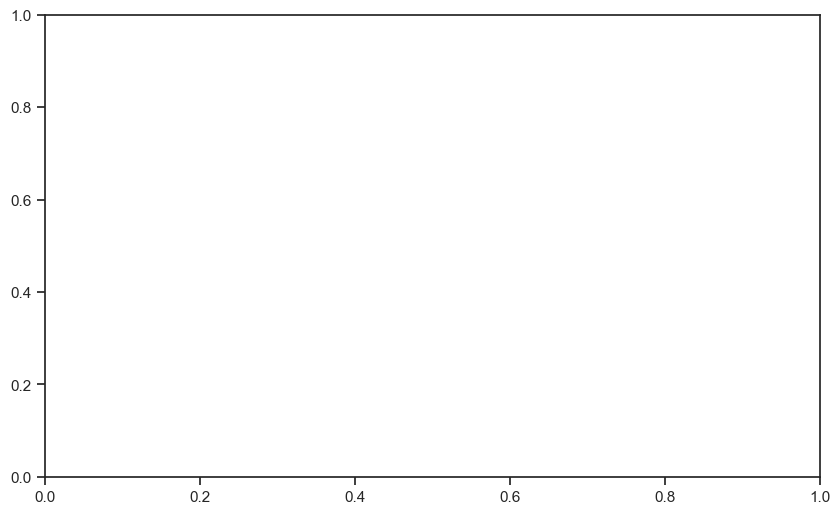

In [204]:
# For rf, we first sort all the csv files by the f1 score.
for key in rf_dict:
    rf_dict[key] = rf_dict[key].sort_values(by="f1_score", ascending=False)

########## PLOTTING ##########
# Now we plot the ALL f1 scores and compare the 2d vs 3d for each marker.

rf_df = pd.DataFrame()
for key in rf_dict:
    # Extract marker from key
    marker = key.split("_")[0]
    # print(marker)
    # Extract the data
    marker_data = rf_dict[key]
    # Extract dimension
    dim = key.split("_")[1].replace("test", "")
    # Extract val/test
    val_test = key.split("_")[2].replace(".csv", "") if "val" in key else "test"

    # create new columns for dimension and marker
    marker_data["Dimension"] = dim
    marker_data["Marker"] = marker
    marker_data["dataset"] = val_test
    # Append to the main dataframe
    rf_df = pd.concat([rf_df, marker_data])



# For each Marker, create a plot comparing metrics between 2D and 3D.
def create_plot_for_marker(rf_df):
    for marker in rf_df["Marker"].unique():
        # Filter the data for the current marker
        marker_data = rf_df[rf_df["Marker"] == marker]
        print(marker_data)

        # Set up the plot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Define a new color palette for markers (more harmonious colors)
        palette = {
            'PU1': '#606c38',
            'SCA1': '#283618',
            'GATA1': '#dda15e',
            'CD41': '#bc6c25'
        }

        metric_map = {'accuracy': 1, 'f1_score': 3, 'precision': 5, 'recall': 7}
        
        for dataset in marker_data["dataset"].unique():
            # Filter the data for the current dataset
            dataset_data = marker_data[marker_data["dataset"] == dataset]
            # print(dataset_data)
            
            for metric in ["accuracy", "f1_score", "precision", "recall"]:
                metric_data = dataset_data[metric]
                
                x_pos = dataset_data["Dimension"].map(dim_value) + metric_map[metric]
                y_pos = metric_data

                # Color based on palette
                color = palette[marker]

                # Plot barplots
                ax.boxplot(x_pos, y_pos, label=dataset, color=color, marker='o', linestyle='-', linewidth=3)
                

        # Customize axes
        # ax.set_xticks([1.5, 3.5, 5.5, 7.5], labels=['Accuracy', 'F1', 'Precision', 'Recall'])
        ax.set_yticks([0, 1])

create_plot_for_marker(rf_df)
# Create positional encoding column for x-axis
# rf_df['x_positional_encoding'] = rf_df['Dimension'].map(dim_value) + rf_df['']


In [179]:
print(rf_df.head)

<bound method NDFrame.head of                                              Unnamed: 0  accuracy  precision  \
525   rf_model_4_20_entropy_20_5_5_True_sqrt_balance...  0.576271   0.114786   
265   rf_model_2_10_log_loss_20_5_3_True_sqrt_balanc...  0.651204   0.115764   
449   rf_model_2_20_log_loss_20_2_5_True_sqrt_balanc...  0.611954   0.111354   
568   rf_model_2_20_entropy_30_5_5_True_sqrt_balance...  0.566459   0.107900   
422   rf_model_2_20_entropy_20_5_3_True_sqrt_balance...  0.617306   0.109375   
...                                                 ...       ...        ...   
1075   rf_model_2_10_gini_10_5_1_True_sqrt_balanced.pkl  0.966425   1.000000   
1076  rf_model_4_10_entropy_10_2_1_True_sqrt_balance...  0.966425   1.000000   
1077   rf_model_0_10_gini_30_5_1_True_sqrt_balanced.pkl  0.965517   1.000000   
1078  rf_model_4_10_log_loss_10_5_5_True_sqrt_balanc...  0.964610   1.000000   
1079  rf_model_4_10_log_loss_20_2_1_True_sqrt_balanc...  0.961887   1.000000   

        r

In [ ]:
pri

In [173]:
print(logreg_dict.keys())
print(logreg_dict["SCA1_metrics_3d.txt"]['Test'])
# print(rf_dict.keys())
# print(rf_dict["SCA1_3Dtest_results.csv"].head())

dict_keys(['PU1_metrics_3d.txt', 'PU1_metrics_2d.txt', 'SCA1_metrics_3d.txt', 'SCA1_metrics_2d.txt', 'GATA1_metrics_3d.txt', 'GATA1_metrics_2d.txt', 'CD41_metrics_3d.txt', 'CD41_metrics_2d.txt'])
Accuracy      0.5301302931596091
Precision    0.20684292379471228
Recall                     0.665
F1            0.3155397390272835
ROC AUC       0.6164494163424125
PR AUC        0.2506347303223558
TP                           133
FP                           510
TN                           518
FN                            67
Name: Test, dtype: object
